In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

In [4]:
actors

Info                                        \
                        ordering Wikipedia movie ID         Movie name   
IMDb_ID   IMDb_actor_ID                                                  
tt0228333 nm0000449            1             975900     Ghosts of Mars   
tt0114508 nm0000449            1             689763            Species   
tt0120841 nm0000449            1             704406         Species II   
tt0129884 nm0000449            1             761361           Dog Park   
tt0244196 nm0000449            1             355807        Second Skin   
...                          ...                ...                ...   
tt0120514 nm0000410            1            1191380              Wilde   
tt0100666 nm0056492            1            7761830    Spaced Invaders   
tt0048223 nm0827409            1           28373912          Jan Zizka   
tt1606259 nm4774206            1           34980460            Knuckle   
tt0362411 nm0514648            1            9971909  Another Nice Mess   

                                                                  Features  \
                        Movie release date           primaryName birthYear   
IMDb_ID   IMDb_actor_ID                                                      
tt0228333 nm0000449                   2001    Natasha Henstridge      1974   
tt0114508 nm0000449                   1995    Natasha Henstridge      1974   
tt0120841 nm0000449                   1998    Natasha Henstridge      1974   
tt0129884 nm0000449                   1998    Natasha Henstridge      1974   
tt0244196 nm0000449                   2000    Natasha Henstridge      1974   
...                                    ...                   ...       ...   
tt0120514 nm0000410                   1997           Stephen Fry      1957   
tt0100666 nm0056492                   1990          Douglas Barr      1949   
tt0048223 nm0827409                   1956       Zdenek Stepánek      1896   
tt1606259 nm4774206                   2011  James Quinn McDonagh        \N   
tt0362411 nm0514648                   1972           Rich Little      1938   

                                                                          \
                        awards nominations movie_count movie_count_genre   
IMDb_ID   IMDb_actor_ID                                                    
tt0228333 nm0000449          0           0           5                 3   
tt0114508 nm0000449          0           0           1                 1   
tt0120841 nm0000449          0           0           3                 2   
tt0129884 nm0000449          0           0           3                 2   
tt0244196 nm0000449          0           0           4                 3   
...                        ...         ...         ...               ...   
tt0120514 nm0000410          0           0           1                 1   
tt0100666 nm0056492          0           0           1                 0   
tt0048223 nm0827409          0           0           1                 0   
tt1606259 nm4774206          0           0           1                 0   
tt0362411 nm0514648          0           0           1                 0   

                                                         
                        genres_b4 isMale age_at_release  
IMDb_ID   IMDb_actor_ID                                  
tt0228333 nm0000449            17      0             27  
tt0114508 nm0000449             2      0             21  
tt0120841 nm0000449             5      0             24  
tt0129884 nm0000449             5      0             24  
tt0244196 nm0000449            10      0             26  
...                           ...    ...            ...  
tt0120514 nm0000410             4      1             40  
tt0100666 nm0056492             1      1             41  
tt0048223 nm0827409             1   <NA>             60  
tt1606259 nm4774206            11   <NA>           <NA>  
tt0362411 nm0514648             3      1             34  

[27622 rows x 13 col

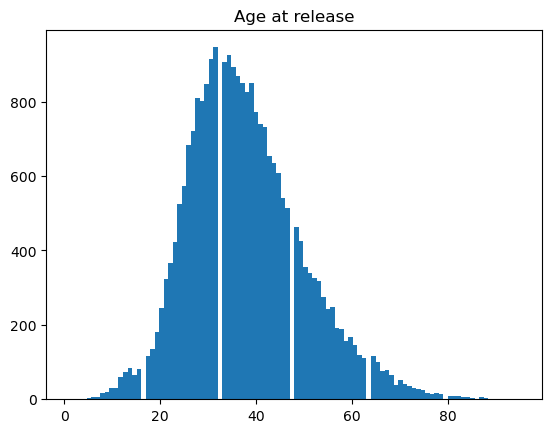

In [5]:
plt.hist(actors['Features']['age_at_release'].dropna(), bins=100)

plt.title('Age at release')
plt.show()




In [58]:
actors

Info                                        \
                        ordering Wikipedia movie ID         Movie name   
IMDb_ID   IMDb_actor_ID                                                  
tt0228333 nm0000449            1             975900     Ghosts of Mars   
tt0114508 nm0000449            1             689763            Species   
tt0120841 nm0000449            1             704406         Species II   
tt0129884 nm0000449            1             761361           Dog Park   
tt0244196 nm0000449            1             355807        Second Skin   
...                          ...                ...                ...   
tt0120514 nm0000410            1            1191380              Wilde   
tt0100666 nm0056492            1            7761830    Spaced Invaders   
tt0048223 nm0827409            1           28373912          Jan Zizka   
tt1606259 nm4774206            1           34980460            Knuckle   
tt0362411 nm0514648            1            9971909  Another Nice Mess   

                                                                  Features  \
                        Movie release date           primaryName birthYear   
IMDb_ID   IMDb_actor_ID                                                      
tt0228333 nm0000449                   2001    Natasha Henstridge      1974   
tt0114508 nm0000449                   1995    Natasha Henstridge      1974   
tt0120841 nm0000449                   1998    Natasha Henstridge      1974   
tt0129884 nm0000449                   1998    Natasha Henstridge      1974   
tt0244196 nm0000449                   2000    Natasha Henstridge      1974   
...                                    ...                   ...       ...   
tt0120514 nm0000410                   1997           Stephen Fry      1957   
tt0100666 nm0056492                   1990          Douglas Barr      1949   
tt0048223 nm0827409                   1956       Zdenek Stepánek      1896   
tt1606259 nm4774206                   2011  James Quinn McDonagh        \N   
tt0362411 nm0514648                   1972           Rich Little      1938   

                                                                          \
                        awards nominations movie_count movie_count_genre   
IMDb_ID   IMDb_actor_ID                                                    
tt0228333 nm0000449          0           0           5                 3   
tt0114508 nm0000449          0           0           1                 1   
tt0120841 nm0000449          0           0           3                 2   
tt0129884 nm0000449          0           0           3                 2   
tt0244196 nm0000449          0           0           4                 3   
...                        ...         ...         ...               ...   
tt0120514 nm0000410          0           0           1                 1   
tt0100666 nm0056492          0           0           1                 0   
tt0048223 nm0827409          0           0           1                 0   
tt1606259 nm4774206          0           0           1                 0   
tt0362411 nm0514648          0           0           1                 0   

                                                        ReleaseYearRange  
                        genres_b4 isMale age_at_release                   
IMDb_ID   IMDb_actor_ID                                                   
tt0228333 nm0000449            17      0             27             2000  
tt0114508 nm0000449             2      0             21             1995  
tt0120841 nm0000449             5      0             24             1995  
tt0129884 nm0000449             5      0             24             1995  
tt0244196 nm0000449            10      0             26             2000  
...                           ...    ...            ...              ...  
tt0120514 nm0000410             4      1             40             1995  
tt0100666 nm0056492             1      1             41             1990  
tt004822

Text(0.5, 1.0, 'Movie count')

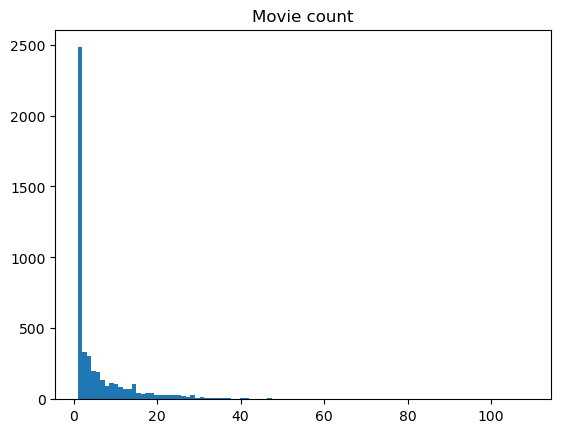

In [69]:
plt.hist(test['movie_count'].dropna(), bins=100)

plt.title('Movie count')

Text(0.5, 1.0, 'Movie count in drama')

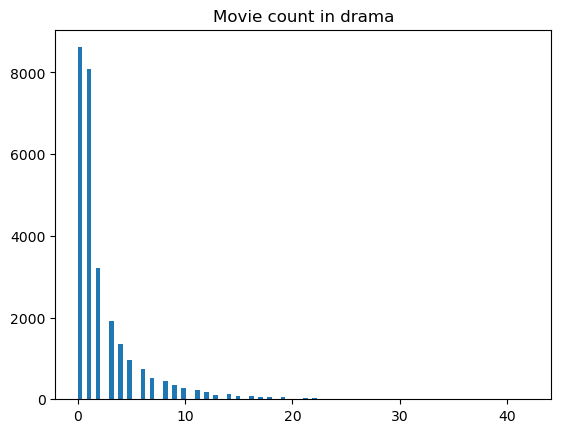

In [7]:
plt.hist(actors['Features']['movie_count_genre'].dropna(), bins=100)

plt.title('Movie count in drama')

In [44]:


plt.hist(actors['Features']['nominations'].dropna(), bins=50)

plt.title('Number of nominations')

ValueError: Grouper for 'Features' not 1-dimensional

Text(0.5, 1.0, 'Number of awards')

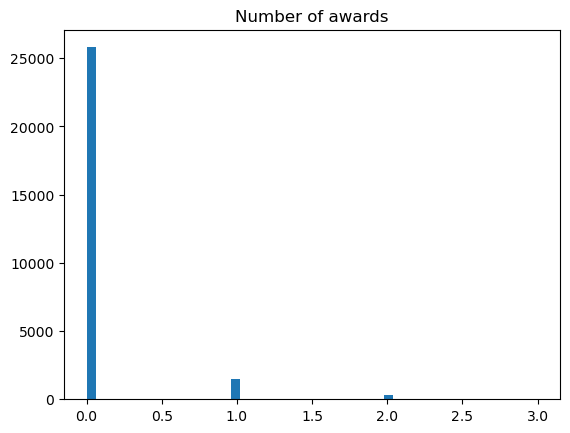

In [9]:
plt.hist(actors['Features']['awards'].dropna(), bins=50)

plt.title('Number of awards')

Text(0.5, 1.0, 'Diversity of genres')

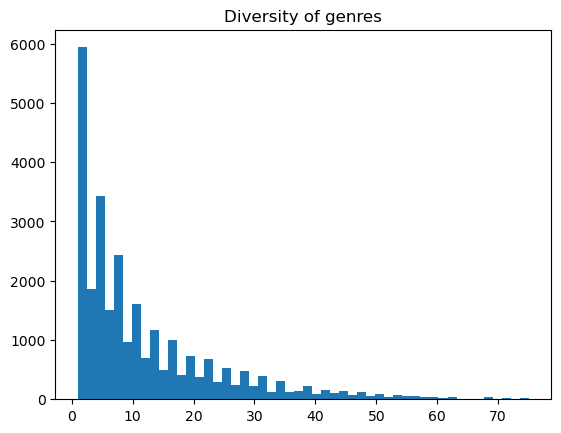

In [10]:
plt.hist(actors['Features']['genres_b4'].dropna(), bins=50)
plt.title('Diversity of genres')

Text(0.5, 1.0, 'Male')

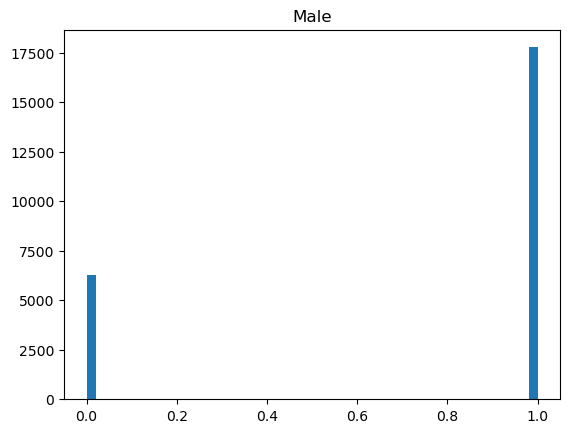

In [11]:
plt.hist(actors['Features']['isMale'].dropna(), bins=50)

plt.title('Male')

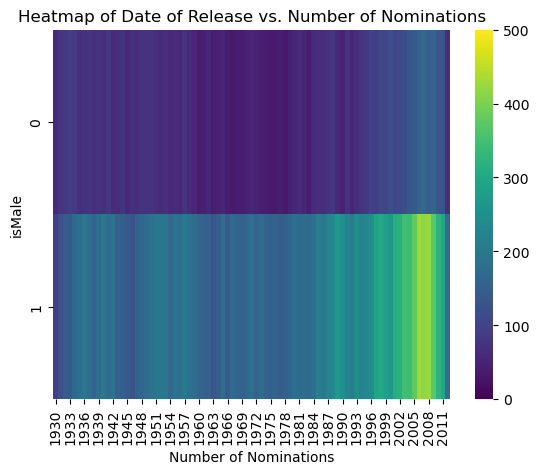

In [12]:

#data = actors.loc[:, ['age_at_release', 'movie_count']]

#sns.histplot(data = data, x='year', y='features', bins=(20, 20), cmap='viridis', cbar=True)
data = actors[['Info', 'Features']].dropna()

date_of_release = data['Info']['Movie release date']
number_of_nominations = data['Features']['isMale']

heatmap_data = data.pivot_table(index=number_of_nominations, columns=date_of_release, aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt='g', cbar=True, vmin=0, vmax=500)
plt.title('Heatmap of Date of Release vs. Number of Nominations')
plt.xlabel('Number of Nominations')
plt.show()


<Axes: xlabel='ReleaseYearRange'>

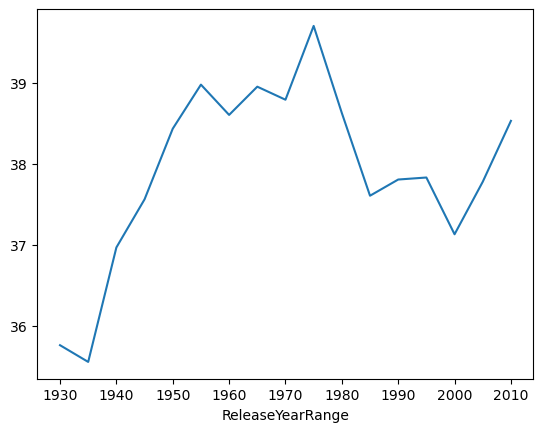

In [13]:
#mode_per_date = actors['Features']['age_at_release'].groupby(actors['Info']['Movie release date']).apply(lambda x: x.mode().iloc[0])
#mode_per_date.plot()

actors['ReleaseYearRange'] = (actors['Info']['Movie release date'] // 5) * 5


#mean_per_date = actors['Features']['age_at_release'].groupby(actors['Info']['Movie release date']).mean()
mean_per_date = actors['Features']['age_at_release'].groupby(actors['ReleaseYearRange']).mean()
mean_per_date.plot()


In [14]:
actors.reset_index(level=0)

IMDb_ID     Info                                        \
                         ordering Wikipedia movie ID         Movie name   
IMDb_actor_ID                                                             
nm0000449      tt0228333        1             975900     Ghosts of Mars   
nm0000449      tt0114508        1             689763            Species   
nm0000449      tt0120841        1             704406         Species II   
nm0000449      tt0129884        1             761361           Dog Park   
nm0000449      tt0244196        1             355807        Second Skin   
...                  ...      ...                ...                ...   
nm0000410      tt0120514        1            1191380              Wilde   
nm0056492      tt0100666        1            7761830    Spaced Invaders   
nm0827409      tt0048223        1           28373912          Jan Zizka   
nm4774206      tt1606259        1           34980460            Knuckle   
nm0514648      tt0362411        1            9971909  Another Nice Mess   

                                                        Features         \
              Movie release date           primaryName birthYear awards   
IMDb_actor_ID                                                             
nm0000449                   2001    Natasha Henstridge      1974      0   
nm0000449                   1995    Natasha Henstridge      1974      0   
nm0000449                   1998    Natasha Henstridge      1974      0   
nm0000449                   1998    Natasha Henstridge      1974      0   
nm0000449                   2000    Natasha Henstridge      1974      0   
...                          ...                   ...       ...    ...   
nm0000410                   1997           Stephen Fry      1957      0   
nm0056492                   1990          Douglas Barr      1949      0   
nm0827409                   1956       Zdenek Stepánek      1896      0   
nm4774206                   2011  James Quinn McDonagh        \N      0   
nm0514648                   1972           Rich Little      1938      0   

                                                                          \
              nominations movie_count movie_count_genre genres_b4 isMale   
IMDb_actor_ID                                                              
nm0000449               0           5                 3        17      0   
nm0000449               0           1                 1         2      0   
nm0000449               0           3                 2         5      0   
nm0000449               0           3                 2         5      0   
nm0000449               0           4                 3        10      0   
...                   ...         ...               ...       ...    ...   
nm0000410               0           1                 1         4      1   
nm0056492               0           1                 0         1      1   
nm0827409               0           1                 0         1   <NA>   
nm4774206               0           1                 0        11   <NA>   
nm0514648               0           1                 0         3      1   

                             ReleaseYearRange  
              age_at_release                   
IMDb_actor_ID                                  
nm0000449                 27             2000  
nm0000449                 21             1995  
nm0000449                 24             1995  
nm0000449                 24             1995  
nm0000449                 26             2000  
...                      ...              ...  
nm0000410                 40             1995  
nm0056492                 41             1990  
nm0827409                 60             1955  
nm4774206               <NA>             2010  
nm0514648                 34             1970  

[27622 rows x 15 columns]

In [24]:
a = actors.droplevel(0, axis=1)
a = a.reset_index()
display(a)
f = a.merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,awards,nominations,movie_count,movie_count_genre,genres_b4,isMale,age_at_release,
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge,1974,0,0,5,3,17,0,27,2000
1,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge,1974,0,0,1,1,2,0,21,1995
2,tt0120841,nm0000449,1,704406,Species II,1998,Natasha Henstridge,1974,0,0,3,2,5,0,24,1995
3,tt0129884,nm0000449,1,761361,Dog Park,1998,Natasha Henstridge,1974,0,0,3,2,5,0,24,1995
4,tt0244196,nm0000449,1,355807,Second Skin,2000,Natasha Henstridge,1974,0,0,4,3,10,0,26,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27617,tt0120514,nm0000410,1,1191380,Wilde,1997,Stephen Fry,1957,0,0,1,1,4,1,40,1995
27618,tt0100666,nm0056492,1,7761830,Spaced Invaders,1990,Douglas Barr,1949,0,0,1,0,1,1,41,1990
27619,tt0048223,nm0827409,1,28373912,Jan Zizka,1956,Zdenek Stepánek,1896,0,0,1,0,1,<NA>,60,1955
27620,tt1606259,nm4774206,1,34980460,Knuckle,2011,James Quinn McDonagh,\N,0,0,1,0,11,<NA>,<NA>,2010


In [28]:
f.IMDb_actor_ID.isna().sum()

0

<Axes: xlabel='ReleaseYearRange'>

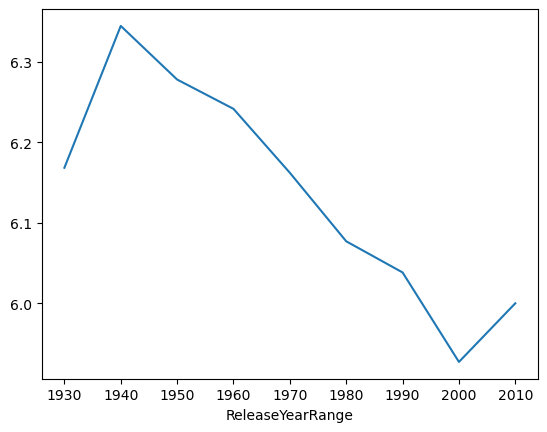

In [42]:
f['ReleaseYearRange'] = (f['Movie release date'] // 10) * 10
movies_by_range = f.groupby('ReleaseYearRange')
movies_by_range['averageRating'].mean().plot()

#f_norm = f.groupby(('Movie release date'// 5) * 5).apply(lambda x: x['averageRating'].mean())

#f_norm.plot()




Text(0, 0.5, 'Movie count')

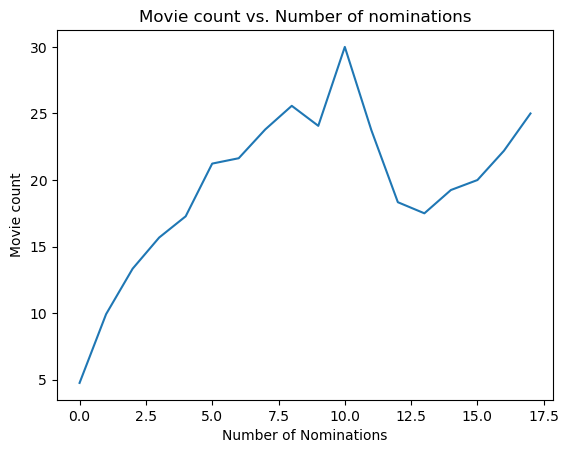

In [56]:
movie_count = actors['Features']['movie_count'].groupby(actors['Features']['nominations']).mean()
plt.plot(movie_count)

plt.title('Movie count vs. Number of nominations')
plt.xlabel('Number of Nominations')
plt.ylabel('Movie count')

Text(0, 0.5, 'Movie count')

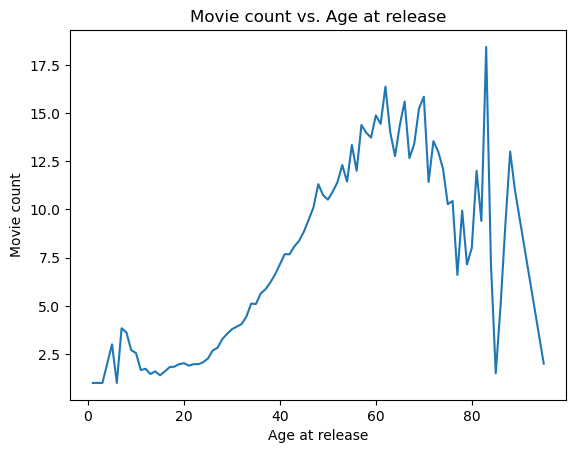

In [57]:
age = actors['Features']['movie_count'].groupby(actors['Features']['age_at_release']).mean()
plt.plot(age)

plt.title('Movie count vs. Age at release')
plt.xlabel('Age at release')
plt.ylabel('Movie count')

In [101]:
median_rating = f['averageRating'].median()
high = f.query('averageRating >= @median_rating')
low = f.query('averageRating < @median_rating')

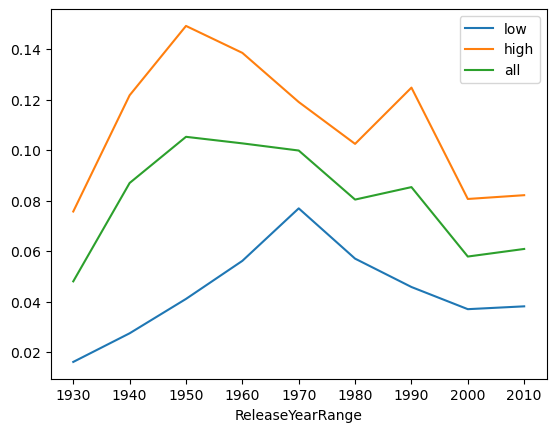

In [130]:
low.groupby('ReleaseYearRange')['awards'].mean().plot()


high.groupby('ReleaseYearRange')['awards'].mean().plot()


f.groupby('ReleaseYearRange')['awards'].mean().plot()
plt.legend(['low', 'high', 'all'])

plt.show()

<BarContainer object of 9 artists>

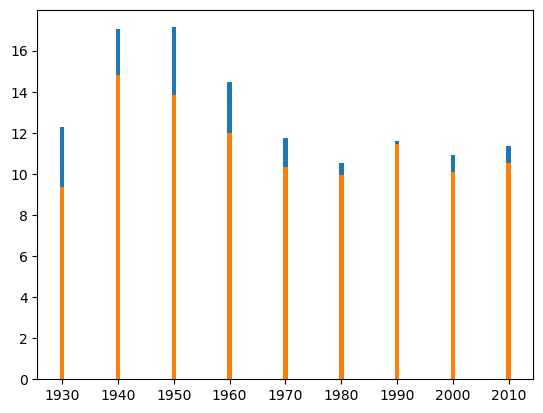

In [128]:


plt.bar(sorted(high['ReleaseYearRange'].unique()), high.groupby('ReleaseYearRange')['genres_b4'].mean())
plt.bar(sorted(low['ReleaseYearRange'].unique()), low.groupby('ReleaseYearRange')['genres_b4'].mean())
